In [ ]:
import os
import argparse
import numpy as np
import pandas as pd
import datetime as dt

bt_dir = '../adr_results/1e-4_var_penalty/'
pnl = pd.read_csv(os.path.join(bt_dir, 'pnl.csv', ), index_col=0, parse_dates=True)
pnl.columns = ['pnl']
gmv = pd.read_csv(os.path.join(bt_dir, 'gmv.csv'), index_col=0, parse_dates=True)
gmv.columns = ['gmv']
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['commission'] = 0.0006 * trade_df['size'].abs()
close_idx = trade_df['timestamp'].str[11:13] == '16'
trade_df.loc[close_idx, 'exchange_fee'] = 0.0016 * trade_df.loc[close_idx, 'size'].abs()
trade_df.loc[~close_idx, 'exchange_fee'] = -0.0018 * trade_df.loc[~close_idx, 'size'].abs()
trade_df['date'] = pd.to_datetime(trade_df['timestamp'].str[:10])

In [ ]:
daily_fees = trade_df.groupby('date')[['commission', 'exchange_fee']].sum()
merged = pnl.merge(daily_fees, left_index=True, right_index=True)
merged['pnl_after_fees'] = merged['pnl'] - merged['commission'] - merged['exchange_fee']
merged = merged.merge(gmv, left_index=True, right_index=True)

In [ ]:
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True, format='mixed')
trades = trade_df.groupby(['timestamp','ticker']).last().reset_index()
trades['pos'] = trades.groupby('ticker')['size'].transform('cumsum')
pos = trades.pivot(index='timestamp',columns='ticker',values='pos').ffill().fillna(0)
price = trades.pivot(index='timestamp',columns='ticker',values='price').ffill().fillna(0)
all_gmv = (pos * price).abs().sum(axis=1)
max_gmv = all_gmv.max()
mean_gmv = all_gmv.resample('1min').min().mean()

In [ ]:
all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = pnl.merge(all_gmv.groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
(gmv_merged['pnl']/gmv_merged['gmv']).mean() * 252

0.06834616002787519

Text(0.95, 0.7, 'Total PnL: $2,143,000\nAnnualized PnL: 450,000\nAnnualized Return: 11.09%\nAnnualized Sharpe: 3.84\n')

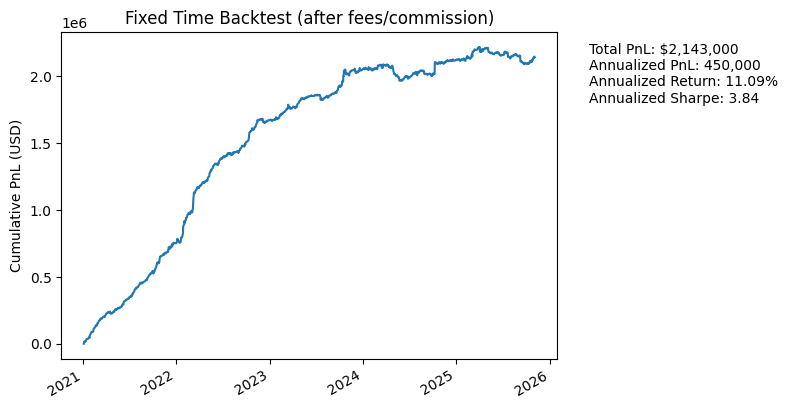

In [ ]:
import matplotlib.pyplot as plt

merged['pnl_after_fees'].cumsum().plot()
plt.title('Fixed Time Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged['pnl_after_fees'].sum() / len(merged)).round(-3):,.0f}\n"
                        f"Annualized Return: {252 * merged['pnl_after_fees'].mean() / mean_gmv:.2%}\n"
                       f"Annualized Sharpe: {np.sqrt(252) * merged['pnl_after_fees'].mean()/merged['pnl_after_fees'].std():.2f}\n")

In [ ]:
import os
import pandas as pd

price_filename = '../data/raw/adrs/adr_PX_LAST_adjust_none.csv'
etf_filename = '../data/raw/etfs/market/market_etf_PX_LAST_adjust_none.csv'
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True)

price_df = pd.read_csv(price_filename, index_col=0, parse_dates=True)
etf_df = pd.read_csv(etf_filename, index_col=0, parse_dates=True)
price_df = pd.concat([price_df, etf_df], axis=1)
trade_df['date'] = trade_df['timestamp'].dt.date

position_df = trade_df[['date','ticker','size']].groupby(['date','ticker'])['size'].sum().unstack().fillna(0).cumsum()
notional_trade_df = trade_df.copy()
notional_trade_df['value'] = notional_trade_df['size'] * notional_trade_df['price']

cash_flow = -notional_trade_df.groupby(['date','ticker'])['value'].sum()
    
position_change = position_df.diff()
position_change.iloc[0] = position_df.iloc[0]
position_value = (position_df * price_df.loc[position_df.index, position_df.columns])

pnl = (position_value - position_value.shift(fill_value=0)) + cash_flow
gmv = position_value.abs()

<Axes: xlabel='date'>

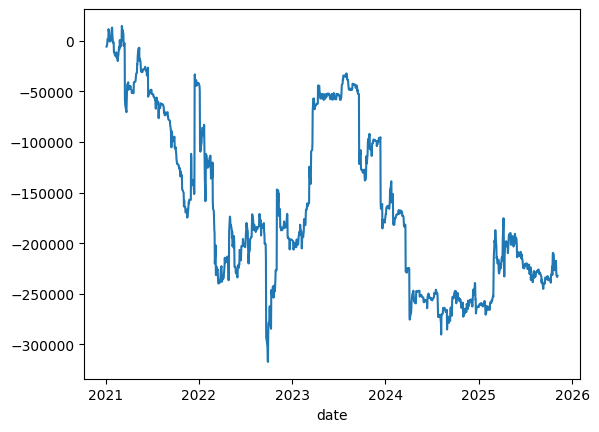

In [109]:
cash_flow.unstack()['FEZ'].cumsum().plot()

In [85]:
by_ticker = cash_flow.unstack()
by_ticker.index = pd.to_datetime(by_ticker.index)


In [86]:
by_ticker['GSK'].sort_values()

date
2022-12-06   -96024.465
2025-05-06   -26837.315
2025-06-18   -19223.250
2025-04-09   -18036.525
2022-06-07   -15715.785
                ...    
2024-10-09    25773.275
2022-05-04    26247.780
2022-07-19          NaN
2022-07-20          NaN
2022-07-21          NaN
Name: GSK, Length: 1200, dtype: float64

In [91]:
open_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).first().reset_index()
open_df['val'] = open_df['size'] * open_df['price']
open_df['val'].sort_values()


15294   -1.203610e+07
15106   -1.136473e+07
15507   -1.014552e+07
14926   -1.008218e+07
15099   -8.826483e+06
             ...     
14660    8.900752e+06
14802    8.943680e+06
15811    9.109081e+06
15431    9.616967e+06
15228    1.049001e+07
Name: val, Length: 47744, dtype: float64

In [92]:
trade_df['date']

0        2021-01-04
1        2021-01-04
2        2021-01-04
3        2021-01-04
4        2021-01-04
            ...    
95483    2025-11-04
95484    2025-11-04
95485    2025-11-04
95486    2025-11-04
95487    2025-11-04
Name: date, Length: 95488, dtype: object

In [93]:
trade_df[(trade_df['ticker']=='GSK') & (trade_df['timestamp'].dt.strftime('%Y-%m-%d')=='2024-10-09')]

,timestamp,ticker,size,price,date
73902,2024-10-09 14:00:00+00:00,GSK,-34595,40.985,2024-10-09
73903,2024-10-09 16:00:00+00:00,GSK,34595,40.240,2024-10-09


In [94]:
close_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).last().reset_index()
prices = close_df[['date','ticker','price']].merge(open_df[['date','ticker','price']], on=['date','ticker'], suffixes=('_close','_open'))
prices['date'] = pd.to_datetime(prices['date']).dt.strftime('%Y-%m-%d')
((prices['price_open'] - prices['price_close'])>0).sum()/len(prices)

0.4821548257372654

In [95]:
prices[prices['date'] == '2024-10-09']

,date,ticker,price_close,price_open
936,2024-10-09,AEG,6.240,6.225
2129,2024-10-09,ARGX,520.520,518.575
3320,2024-10-09,ASML,845.900,840.565
4510,2024-10-09,AZN,77.505,77.320
5710,2024-10-09,BBVA,10.150,10.165
6910,2024-10-09,BCS,12.190,12.215
8110,2024-10-09,BP,31.980,32.025
9309,2024-10-09,BTI,35.480,35.465
10509,2024-10-09,BUD,64.270,64.370
11709,2024-10-09,DB,17.500,17.495


In [121]:
open_df

,ticker,date,timestamp,size,price,val,sign
0,AEG,2021-01-04,2021-01-04 14:00:00+00:00,29885,3.895,116402.075,True
1,AEG,2021-01-05,2021-01-05 14:00:00+00:00,-25488,3.965,-101059.920,False
2,AEG,2021-01-06,2021-01-06 14:00:00+00:00,34393,4.245,145998.285,True
3,AEG,2021-01-07,2021-01-07 14:00:00+00:00,-21813,4.355,-94995.615,False
4,AEG,2021-01-08,2021-01-08 14:00:00+00:00,24969,4.215,105244.335,True
...,...,...,...,...,...,...,...
47739,WPP,2025-10-29,2025-10-29 14:00:00+00:00,5290,23.780,125796.200,True
47740,WPP,2025-10-30,2025-10-30 14:00:00+00:00,14223,19.805,281686.515,True
47741,WPP,2025-10-31,2025-10-31 14:00:00+00:00,-8472,18.900,-160120.800,False
47742,WPP,2025-11-03,2025-11-03 14:00:00+00:00,8167,17.985,146883.495,True


In [129]:
by_ticker

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BP,BTI,BUD,DB,...,SAN,SAP,SHEL,SNN,SNY,TS,TTE,UL,VOD,WPP
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-448.275,1226.610,-2934.720,-2157.215,-1316.100,-3208.495,6857.220,-296.025,2586.150,-591.625,...,-534.575,-0.000,NaN,1242.450,-160.480,1226.625,NaN,1986.270,1292.655,421.680
2021-01-05,127.440,-682.775,-979.440,-2123.345,97.675,208.560,17738.865,-237.250,1350.690,112.755,...,176.575,1883.385,NaN,333.480,-795.555,925.225,NaN,3954.375,2904.150,-318.265
2021-01-06,-171.965,3555.680,297.775,-15.795,-448.450,4057.790,14868.640,-8162.870,-1275.930,-1474.200,...,5397.245,8829.750,NaN,583.680,-8029.515,-3117.000,NaN,6235.725,-2816.400,-123.750
2021-01-07,109.065,2617.830,-1864.070,2593.500,22.230,-1175.750,3788.625,789.195,376.075,980.770,...,-330.960,3080.070,NaN,-668.610,-3964.275,3947.625,NaN,3769.135,670.995,-97.665
2021-01-08,1373.295,272.480,7007.715,-3222.780,578.820,3746.705,-2420.715,-1356.095,-4677.000,3422.625,...,-2175.585,-7331.760,NaN,-926.325,-8363.490,3681.040,NaN,7960.650,-4590.675,-722.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-29,-669.660,3583.580,882.650,-10315.080,1721.320,12061.770,-4270.500,485.900,19980.740,-10097.200,...,-1658.855,5812.425,-9615.925,-1132.980,122.850,-1140.225,-4344.435,2451.895,-2928.330,-1851.500
2025-10-30,-2091.390,-3924.530,-2819.360,491.625,484.925,-1115.015,-1122.510,6353.655,694.400,3816.120,...,1748.175,7672.740,-22099.945,-133.600,-246.785,2251.830,3591.375,-971.235,-333.840,-4195.785
2025-10-31,-1575.575,4770.900,-129.860,-9718.975,-1262.930,-4241.685,-1473.920,5663.945,4866.600,4595.565,...,-130.690,-1254.000,705.945,396.800,811.635,972.860,1742.860,-6074.325,3681.495,-593.040


/tmp/ipykernel_404091/2491717829.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)


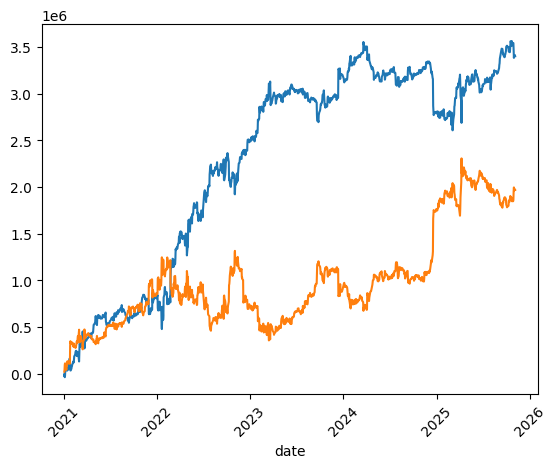

In [137]:
open_df['sign']=(open_df['val']>0)
sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)
long_pnl = (sign_df * by_ticker).sum(axis=1)
short_pnl = ((1-sign_df) * by_ticker).sum(axis=1)

long_pnl.cumsum().plot(label='Long PnL')
short_pnl.cumsum().plot(label='Short PnL')
plt.xticks(rotation=45);

In [17]:
gsk_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=GSK')
gsk_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       43.54
nbbo_ask       43.55
nbbo_bid_sz     1434
nbbo_ask_sz      546
Name: 2025-10-09 13:30:00-04:00, dtype: object

In [18]:
ticker = 'DB'
db_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=DB')
db_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       35.04
nbbo_ask       35.05
nbbo_bid_sz     1500
nbbo_ask_sz      441
Name: 2025-10-09 13:30:00-04:00, dtype: object

In [46]:
ret_sign = trade_df.sort_values('timestamp').groupby(['date','ticker'])['price'].apply(lambda x: np.sign(x.iloc[-1]-x.iloc[0]))
trade_sign = np.sign(trade_df.sort_values('timestamp').groupby(['date','ticker'])['size'].first())
trade_sign

date        ticker
2023-07-20  AEG      -1
            ARGX      1
            ASML      1
            AZN       1
            BBVA     -1
                     ..
2025-11-04  TS       -1
            TTE       1
            UL       -1
            VOD       1
            WPP       1
Name: size, Length: 22150, dtype: int64

0.5110609480812641